# Устарело (смотреть блокнот square_cropping)
# Подготовка датасета для экпериментального метода аугментации данных при помощи модели Stable Diffusion

Для увеличения объема примеров обнаружения объектов в датасете, предлагаем метод который при помощи модели Stable Diffusion может в значительное количество раз увеличить объем, предлагая различного рода объекты. 

Для более лучшей генерации необходимо сделать файнтюнинг модели, для этого создадим собственный датасет для файнтюнинга. Возьмем пример датасета `lambdalabs/pokemon-blip-captions`, и наш датасет `object detection` в формате `COCO` и проведем `promt engeniring` чо бы сформировать датасет для файнтюнинга `Stable Diffusion`

In [3]:
from datasets import load_dataset, Dataset, load_from_disk
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tqdm.notebook import tqdm

In [5]:
ds = load_dataset("lambdalabs/pokemon-blip-captions", split="train")
sample = ds[0]

Using custom data configuration lambdalabs--pokemon-blip-captions-baa94796864cc987


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/833 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/lambdalabs___parquet/lambdalabs--pokemon-blip-captions-baa94796864cc987/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


In [11]:
ds[240]['image'].size

(431, 431)

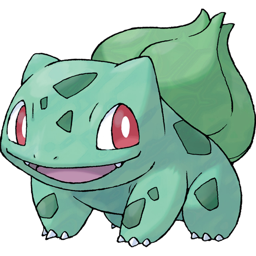

In [3]:
sample['image'].resize((256, 256))

In [4]:
sample["text"]

'a drawing of a green pokemon with red eyes'

Формат к которому необходимо прийти это словарь 

```
{
'image':Pillow.Image,
'text':promt_text
}
```

Взглянем на наш датасет с `object detection`  в  формат COCO. 

In [5]:
ann_file = '../dataset/pipe/for_stable_diffusion/coco/crack/result.json'
dataset_path = '../dataset/pipe/for_stable_diffusion/coco/crack/images'

In [6]:
coco = COCO(ann_file)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


Посмотрим какие категории есть

In [7]:
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO Категории: \n{}'.format(' '.join(nms)))

COCO Категории: 
Трещина


Взглянем, а есть ли вообще изображения на которых могут присудствовать несколько классов однавременно

In [8]:
catIds = coco.getCatIds(catNms=['Homer', 'Marge', 'Lisa']) # Получаем те id которые содержат выбранные нами категории
imgIds = coco.getImgIds(catIds=catIds ) # получаем изображения где есть наши категории 
img = coco.loadImgs(imgIds[0])[0] # получаем первое изображение из выбранных
img_path = img["file_name"].replace("\\", "/") # делаем замену windows на linux пути 

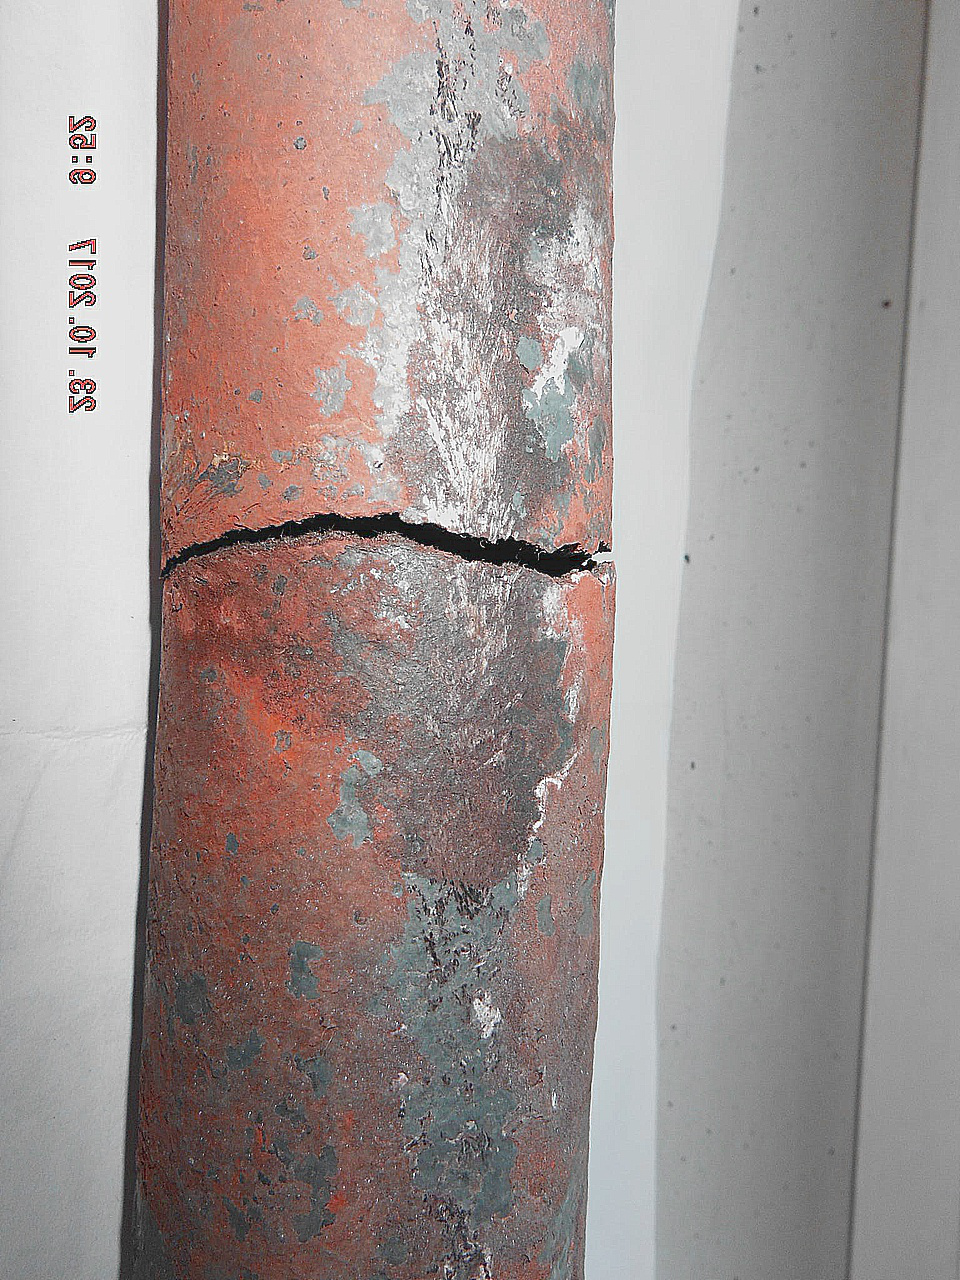

In [9]:
im = Image.open(f"{dataset_path}/{img_path}")
im

Наложим аннотации, на изображение

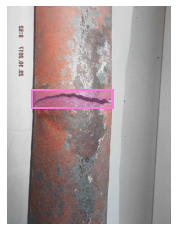

In [10]:
plt.imshow(im); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns, draw_bbox=True)

И поскольку у нас есть фото где могут быть несколько объектов разом, необходимо обрезать объект

(-0.5, 472.5, 102.5, -0.5)

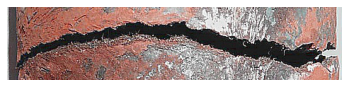

In [11]:
x, y, w,h = [int(x) for x in anns[0]['bbox']]
im_np = np.array(im)[y:y+h, x:x+w]
plt.imshow(im_np); plt.axis('off')

Поэтому мы будем идти по изображениям и если в них есть несколько классов, то будем обрезать. При обрезаении изображение неоходимо сделать кроп примерно в 5% от всего изображения. 

In [12]:
imgs = coco.imgs

In [13]:
imgs = list(imgs.values())

In [14]:
len(imgs)

4

In [15]:
labelid2text = {0:'crack'} # Конвертация id класса в название

Можно использовать несколько promt, на одно изображение описаывая детально объект, вставляя всего лишь его класс. Для этого создадим шаблон и фунцию которая будет генерировать. 

In [16]:
PROMT_TEMAPLTE = [
    'Photo of a <OBJ> on a metal pipe',
    '<OBJ> on a metal pipe'
]

In [17]:
def generate_promt(obj:str):
    return [x.replace('<OBJ>', obj) for x in PROMT_TEMAPLTE]

In [18]:
SCALE_PADDING_PERCENT = 0.2

In [19]:
new_dataset = []
for img in tqdm(imgs):
    ann_id = coco.getAnnIds(imgIds=img['id'], iscrowd=None)
    ann_img = coco.loadAnns(ann_id)
    img_path = img["file_name"].replace("\\", "/") # делаем замену windows на linux пути
    print(img_path)
    img_org = Image.open(f"{dataset_path}/{img_path}")
    org_w, org_h = img_org.size
    padding_w, padding_h = int(org_w*SCALE_PADDING_PERCENT), int(org_h*SCALE_PADDING_PERCENT)
    for ann in ann_img:
        x, y, w,h = [int(x) for x in ann['bbox']]
        crop_y1, crop_y2 = y-padding_h, y+h+padding_h
        crop_x1, crop_x2 = x-padding_w, x+w+padding_w
        if crop_x2 > org_w:
            crop_x2 = org_w
        if crop_y2 > org_h:
            crop_y2 = org_h
        if crop_x1 < 0:
            crop_x1 = 0
        if crop_y1 < 0:
            crop_y1 = 0
        
        im_np = np.array(img_org)[ crop_y1:crop_y2, crop_x1:crop_x2]
        cr_img = Image.fromarray(im_np)
        generated_promt = generate_promt(labelid2text[ann['category_id']])
        for promt in generated_promt:
            new_dataset.append({
                'text': promt,
                'image': cr_img
            })

  0%|          | 0/4 [00:00<?, ?it/s]

239_7_8984.jpg
44_5_0078.jpg
46_7_9b5c.jpg
237_8_1548.jpg


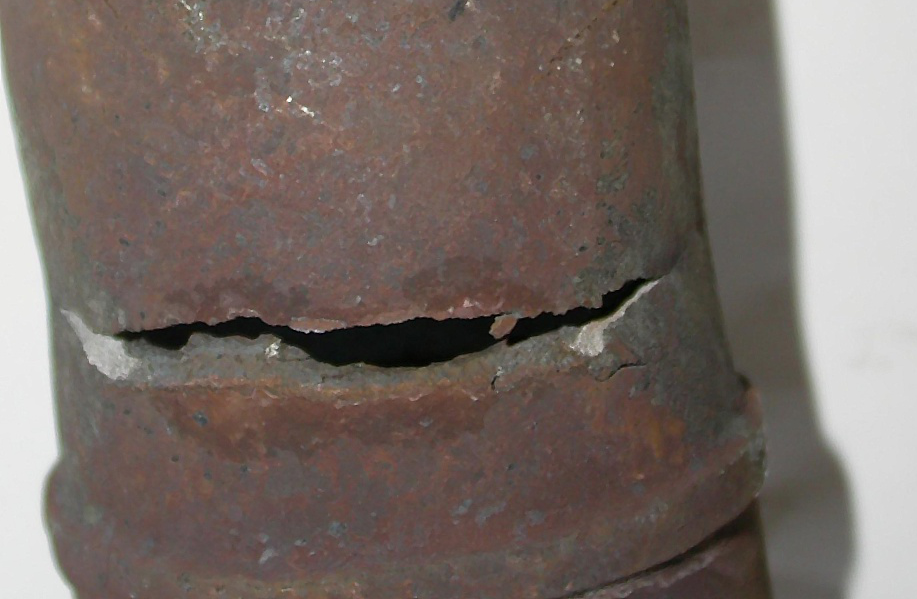

In [20]:
new_dataset[3]['image']

In [21]:
from datasets import Dataset
dataset = Dataset.from_list(new_dataset) # Загрузим датасет из списка в объект 

In [22]:
len(dataset) # Посмотрим на объем класса 

8

In [23]:
for i in range(len(new_dataset)):
    if i % 2 == 0:
        new_dataset[i]["image"].save(f"../dataset/pipe/for_stable_diffusion/croped/crack/{i}_crack.jpg")

In [24]:
dataset.save_to_disk('../dataset/promt_datasets') # Сохраним на диск датасе

In [25]:
new_dataset = Dataset.load_from_disk('../dataset/promt_datasets')

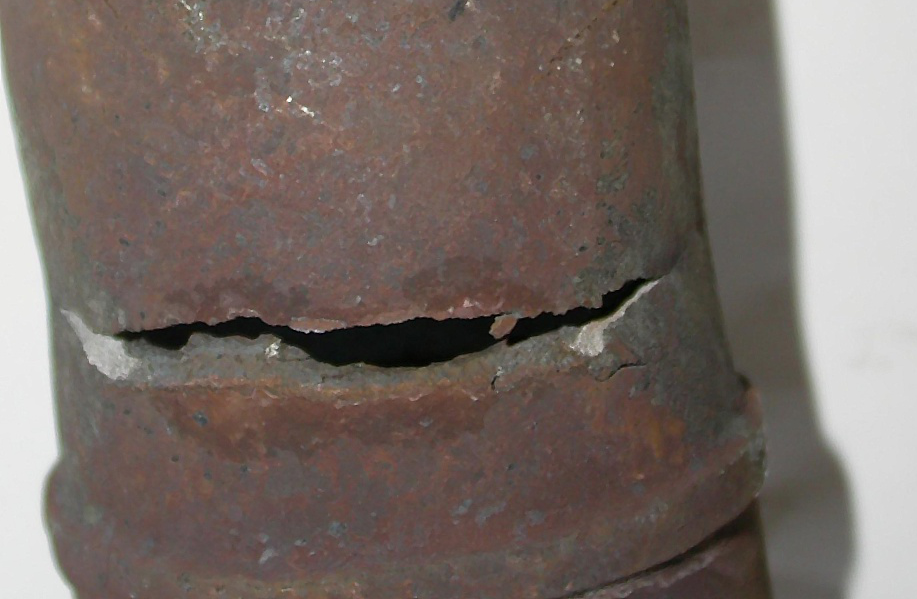

In [29]:
new_dataset[3]['image']

In [30]:
new_dataset[3]['text']

'crack on a metal pipe'